In [19]:
import sys
import os
from copy import deepcopy
# direc = os.path.dirname(__file__)
# pri&
# caution: path[0] is reserved for script path (or '' in REPL)
# print(str(path)+'/ppo')
sys.path.insert(1, '/Users/faridounet/PhD/TransportersDilemma')
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 

from sb3_contrib.ppo_mask import MaskablePPO
# from stable_baselines3 import PPO
from assignment import NormalizedEnv, RemoveActionEnv, AssignmentGame
from a_star import A_Star
from SA_baseline import recuit
from greedy_baseline import baseline
from sb3_contrib.common.maskable.utils import get_action_masks
import pickle

i_id = 0
K = 100
with open(f'game_K{K}.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'routes_K{K}.npy')
dests = np.load(f'destinations_K{K}.npy')
env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
                    #   obs_mode='action', 
                    action_mode = 'all_nodes',
                      change_instance = False, rewards_mode='normalized_terminal', instance_id = i_id)

In [16]:
print(g.distance_matrix)

[[ 0.  3.  5. ... 37. 39. 41.]
 [ 3.  0.  2. ... 36. 38. 40.]
 [ 5.  2.  0. ... 38. 40. 42.]
 ...
 [37. 36. 38. ...  0.  2.  4.]
 [39. 38. 40. ...  2.  0.  2.]
 [41. 40. 42. ...  4.  2.  0.]]


<Axes: >

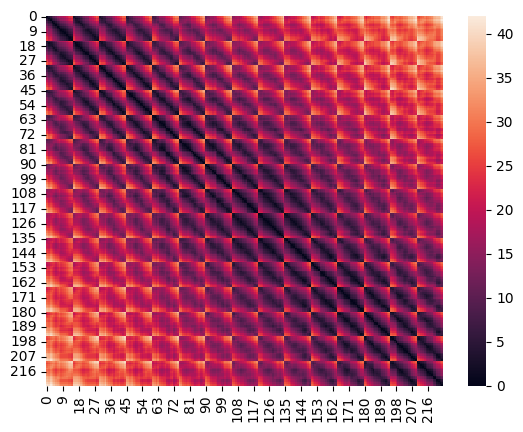

In [17]:
g.distance_matrix.shape
sns.heatmap(g.distance_matrix)

<Axes: >

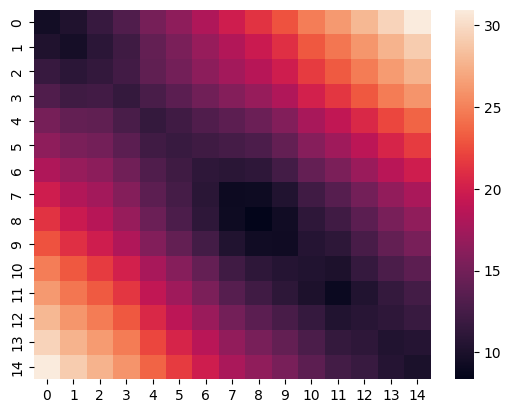

In [18]:
import skimage.measure

M = skimage.measure.block_reduce(g.distance_matrix, (15,15), np.mean)
sns.heatmap(M)

<Axes: >

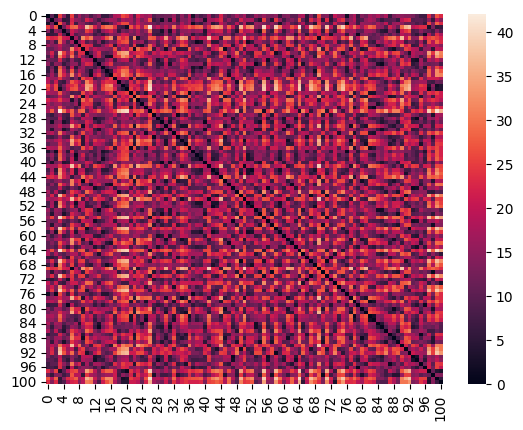

In [13]:
env.reset()
sns.heatmap(env._env.distance_matrix)

In [20]:
env.reset()
destinations = [p.destination for p in env._env._game.packages]
# print(dests[i_id])
# print(env._env.destinations)
assert (env._env.destinations == destinations).all()
assert (env._env.destinations == dests[i_id]).all()
assert env._env._game.CO2_penalty == 10_000
k = 0

In [3]:
# k += 1
# print(dests[k])
# print(len(set(dests[43]).intersection(set(dests[3])))/50)

In [21]:
res_A = A_Star(deepcopy(env._env))#, max_time=120)
action_SA, *_ = recuit(deepcopy(env._env), 5000, 1,0.9999, H=100_000)
res_GTS = baseline(deepcopy(env._env))

A* evaluated 2200 different assignments
m = 85168
6384.0


In [22]:
env.reset()
action_A = res_A['solution'].astype(int)
a = dests[i_id][np.where(action_A == 0)].astype(int)
o, r_A, d, _, info = env.step(a)
# assert (o == action_A).all()
print(r_A, d)
print('omitted : ', K- np.count_nonzero(action_A))

print(info)

0.90584 True
omitted :  25
{'solution_found': False, 'costs': 916.0, 'time_per_vehicle': array([0., 0., 0., 0.]), 'distance_per_vehicle': array([84., 57., 62., 26.]), 'excess_emission': -0.05000000000000426, 'omitted': array([ 1,  2,  7, 10, 12, 14, 15, 16, 17, 28, 31, 35, 37, 38, 39, 51, 59,
       60, 66, 72, 74, 77, 85, 88, 94])}


In [23]:
env.reset()
a = dests[i_id][np.where(action_SA == 0)].astype(int)
o, r_SA, d, _, info = env.step(a)
assert (env._env.destinations == dests[i_id]).all()
# assert (o == action_SA).all()
if not d:
    _, r_SA, *_ = env._env.step(action_SA)
print(r_SA, d)
print('omitted : ', K- np.count_nonzero(action_SA))
print(info)

0.93616 True
omitted :  16
{'solution_found': False, 'costs': 944.0, 'time_per_vehicle': array([0., 0., 0., 0.]), 'distance_per_vehicle': array([84., 72., 33., 47.]), 'excess_emission': -0.20000000000000284, 'omitted': array([ 1, 10, 17, 26, 31, 49, 55, 58, 64, 67, 71, 75, 85, 88, 90, 92])}


In [24]:
a_GTS = res_GTS['solution']
env.reset()
a = dests[i_id][np.where(a_GTS == 0)].astype(int)
o, r_GTS, d, _, info = env.step(a)
assert (env._env.destinations == dests[i_id]).all()
# assert (o == a_GTS).all()
print(r_GTS, d)
print('omitted : ', K- np.count_nonzero(a_GTS))
print(info)

0.90584 True
omitted :  25
{'solution_found': False, 'costs': 916.0, 'time_per_vehicle': array([0., 0., 0., 0.]), 'distance_per_vehicle': array([84., 57., 62., 26.]), 'excess_emission': -0.05000000000000426, 'omitted': array([ 1,  2,  7, 10, 12, 14, 15, 16, 17, 28, 31, 35, 37, 38, 39, 51, 59,
       60, 66, 72, 74, 77, 85, 88, 94])}


In [25]:
model = MaskablePPO.load(#f'ppo_mask/rewardMode(normalized_terminal)_steps(500005)/best_model')
                         'MaskablePPO')
#f'best_model')

In [26]:
# retained = list(range(int(0.75*50)))

In [27]:
k = 0
# l = 0
obs, info = env.reset()
while True:
    action_masks = get_action_masks(env)
    a, _states = model.predict(obs, action_masks=action_masks)
    # print(a)
    obs, r_model, d, _, info = env.step(a)
    k+=1
    # if a in retained:
    #     l+=1
    # print('action : ', a)
    if d:
        break
print('r : ', r_model)
print('omitted : ', k)
# print(l/k)
print(info)

ValueError: Error: Unexpected observation shape (225,) for Box environment, please use (100,) or (n_env, 100) for the observation shape.

In [16]:
print(r_model, r_SA)

0.87196 0.92288


In [33]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt
import numpy as np

In [37]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    import pandas as pd
    rolled = pd.Series(values).rolling(window)
    std = np.array(rolled.std())
    mean = np.array(rolled.mean())
    # weights = np.repeat(1.0, window) / window
    return mean, std#np.convolve(values, weights, "valid"), std


def plot_results(log_folder, title="Learning Curve", show_hlines = False):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y, std = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y, label='mean rewards $\pm 2\sigma$')
    plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)
    if show_hlines:
        plt.hlines(r_A, 0, x[-1], label='A*', colors='orange')
        plt.hlines(r_GTS, 0, x[-1], label='GTS', colors='orange')
        plt.hlines(r_SA, 0, x[-1], label='SA', colors='green')
        # plt.hlines(r_model, 0, x[-1], label='model', colors='red')
        # plt.hlines((r_SA+1e5)/1e5, 0, x[-1], label='SA', colors='green')
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.ylim((0.5,1))
    plt.title(title + " Smoothed")
    plt.legend()
    plt.show()

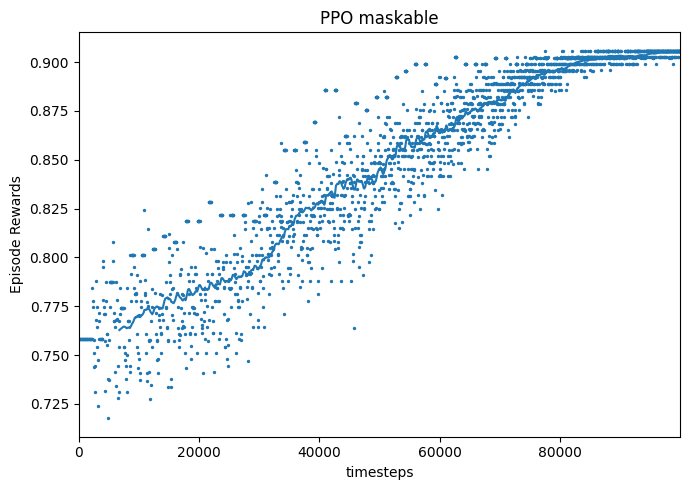

In [40]:
log_dir = f'ppo_mask/rewardMode(normalized_terminal)_steps(100000)_instanceID{i_id}/'
# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "PPO maskable", (7, 5)
)

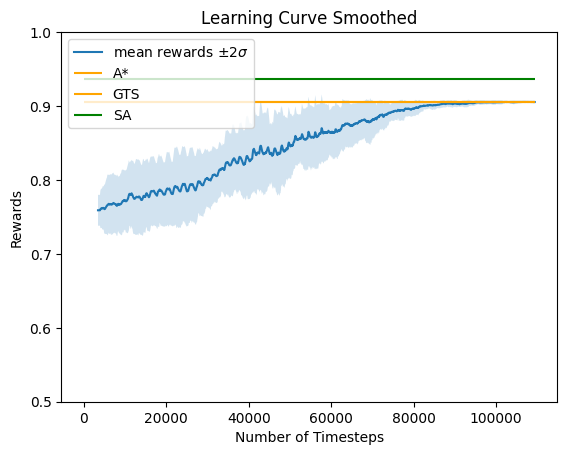

In [41]:
plot_results(log_dir, show_hlines=True)

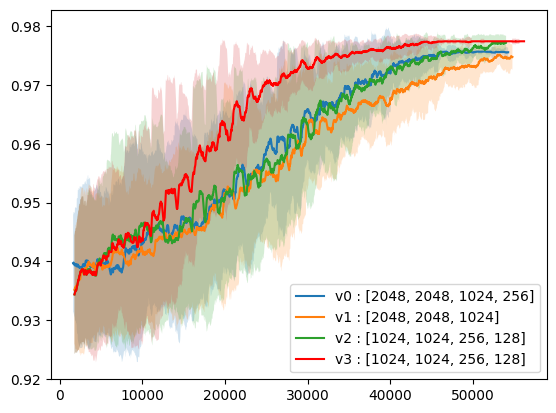

In [15]:
log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(50000)/'
x, y = ts2xy(load_results(log_folder), "timesteps")
y, std = moving_average(y, window=50)
# Truncate x
x = x[len(x) - len(y) :]
fig = plt.figure('title')
plt.plot(x, y, label='v0 : [2048, 2048, 1024, 256]')
plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)

log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(51200)/'
x, y = ts2xy(load_results(log_folder), "timesteps")
y, std = moving_average(y, window=50)
# Truncate x
x = x[len(x) - len(y) :]
fig = plt.figure('title')
plt.plot(x, y, label='v1 : [2048, 2048, 1024]')
plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)

log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(51000)/'
x, y = ts2xy(load_results(log_folder), "timesteps")
y, std = moving_average(y, window=50)
# Truncate x
x = x[len(x) - len(y) :]
fig = plt.figure('title')
plt.plot(x, y, label='v2 : [1024, 1024, 256, 128]')
plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)

log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(51250)/'
x, y = ts2xy(load_results(log_folder), "timesteps")
y, std = moving_average(y, window=50)
# Truncate x
x = x[len(x) - len(y) :]
fig = plt.figure('title')
plt.plot(x, y, label='v3 : [1024, 1024, 256, 128]', color='red')
plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)

plt.legend()

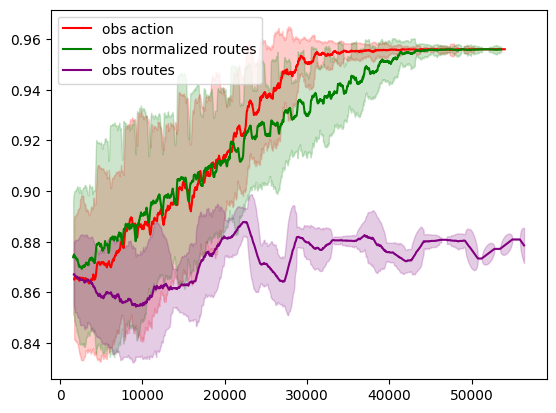

In [40]:
log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(50002)_instanceID0/'
x, y = ts2xy(load_results(log_folder), "timesteps")
y, std = moving_average(y, window=50)
# Truncate x
col = 'red'
x = x[len(x) - len(y) :]
fig = plt.figure('title')
plt.plot(x, y, label='obs action', color=col)
plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2, color = col)


log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(50001)_instanceID0/'
x, y = ts2xy(load_results(log_folder), "timesteps")
y, std = moving_average(y, window=50)
col = 'green'
# Truncate x
x = x[len(x) - len(y) :]
fig = plt.figure('title')
plt.plot(x, y, label='obs normalized routes', color=col)
plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2, color = col)


log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(50003)_instanceID0/'
x, y = ts2xy(load_results(log_folder), "timesteps")
y, std = moving_average(y, window=50)
col = 'purple'
# Truncate x
x = x[len(x) - len(y) :]
fig = plt.figure('title')
plt.plot(x, y, label='obs routes', color=col)
plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2, color = col)

plt.legend()

In [48]:


# ppo = PPO("MlpPolicy", env, verbose=1)
model = MaskablePPO.load(log_dir+'best_model')

In [120]:
k = 0
obs, info = env.reset()
while True:
    action_masks = get_action_masks(env)
    a, _states = model.predict(obs, action_masks=action_masks)
    obs, r, d, _, info = env.step(a)
    k+=1
    # print('action : ', a)
    if d:
        break
print('r : ', r)
print('omitted : ', k)

r :  0.96334
omitted :  18


In [101]:
k = 0
obs, info = env.reset()
acts = list(range(50))
while True:
    # action_masks = get_action_masks(env)
    a = np.random.choice(acts)
    acts.remove(a)
    obs, r, d, _, info = env.step(a)
    k+=1
    # print('action : ', a)
    if d:
        break
print('r : ', r)
print('omitted : ', k)

r :  0.93742
omitted :  34


In [9]:
a = np.zeros(10)
a[-10:] = 1
a

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [29]:
params = model.get_parameters()
params['policy'].keys()

odict_keys(['mlp_extractor.policy_net.0.weight', 'mlp_extractor.policy_net.0.bias', 'mlp_extractor.policy_net.2.weight', 'mlp_extractor.policy_net.2.bias', 'mlp_extractor.policy_net.4.weight', 'mlp_extractor.policy_net.4.bias', 'mlp_extractor.policy_net.6.weight', 'mlp_extractor.policy_net.6.bias', 'mlp_extractor.policy_net.8.weight', 'mlp_extractor.policy_net.8.bias', 'mlp_extractor.value_net.0.weight', 'mlp_extractor.value_net.0.bias', 'mlp_extractor.value_net.2.weight', 'mlp_extractor.value_net.2.bias', 'mlp_extractor.value_net.4.weight', 'mlp_extractor.value_net.4.bias', 'mlp_extractor.value_net.6.weight', 'mlp_extractor.value_net.6.bias', 'mlp_extractor.value_net.8.weight', 'mlp_extractor.value_net.8.bias', 'action_net.weight', 'action_net.bias', 'value_net.weight', 'value_net.bias'])

In [12]:
import numpy as np
evals = np.load('ppo_mask/evaluations.npz')

In [13]:
evals.files

['timesteps', 'results', 'ep_lengths']

In [17]:
evals['ep_lengths']

array([[37, 38, 39, 41, 41],
       [35, 38, 39, 40, 42],
       [36, 40, 41, 41, 42],
       [34, 40, 40, 40, 41],
       [36, 37, 42, 42, 44],
       [33, 41, 43, 43, 43],
       [34, 37, 39, 40, 41],
       [37, 39, 41, 43, 43],
       [37, 39, 42, 42, 43],
       [36, 37, 37, 39, 44],
       [37, 38, 40, 41, 41],
       [37, 38, 40, 42, 43],
       [35, 36, 38, 41, 41],
       [37, 37, 40, 41, 42],
       [34, 35, 40, 41, 43],
       [37, 38, 39, 41, 45],
       [37, 38, 38, 41, 42],
       [31, 38, 38, 40, 40],
       [36, 38, 39, 41, 42],
       [37, 38, 40, 40, 43],
       [36, 38, 39, 40, 41],
       [37, 40, 40, 41, 43],
       [32, 39, 40, 40, 43],
       [36, 39, 40, 41, 41],
       [37, 39, 39, 39, 41],
       [33, 34, 39, 42, 42],
       [33, 37, 38, 40, 45],
       [39, 39, 41, 41, 43],
       [37, 38, 39, 39, 41],
       [37, 37, 38, 39, 42],
       [39, 40, 40, 41, 41],
       [37, 38, 40, 41, 45],
       [31, 34, 38, 38, 43],
       [35, 36, 36, 38, 45],
       [36, 40

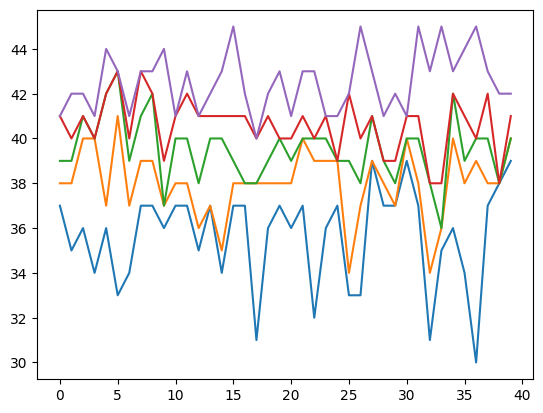

In [18]:
import matplotlib.pyplot as plt
plt.plot(evals['ep_lengths'])

In [10]:
ll = deepcopy(l)
ll.remove(1)
print(deepcopy(l).remove(1))
print(ll)
print(l)

None
[2, 3]
[1, 2, 3]


In [1]:
# from transporter_env import TransportEnv, MAT, OneDynamicTransporter


# env = MAT(max_capacity=10)#size=12, transporters_hubs=(27, 116), horizon=128)
# env = OneDynamicTransporter()

In [7]:
import gymnasium as gym

import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import SubprocVecEnv
from copy import deepcopy
from stable_baselines3.common.utils import set_random_seed

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/Users/faridounet/PhD/TransportersDilemma')


from assignment import AlterActionEnv

def make_env(env, rank: int, seed: int = 0):
    """
    Utility function for multiprocessed env.

    :param env_id: the environment ID
    :param num_env: the number of environments you wish to have in subprocesses
    :param seed: the inital seed for RNG
    :param rank: index of the subprocess
    """
    def _init():
        env2 = deepcopy(env)
        env2.reset(seed=seed + rank)
        return env2
    set_random_seed(seed)
    return _init

# Create environment
env = AlterActionEnv(rewards_mode = 'terminal')
check_env(env)
num_cpu = 6
vec_env = SubprocVecEnv([make_env(env, i) for i in range(num_cpu)])
print(type(env))

<class 'assignment.AlterActionEnv'>


In [30]:
space = gym.spaces.MultiBinary(50)
space.sample()

array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0], dtype=int8)

In [8]:


# Instantiate the agent
model = PPO("MlpPolicy", vec_env)#, verbose=1)
# Train the agent and display a progress bar
model.learn(total_timesteps=int(2e4), progress_bar=True, log_interval=100,)
# Save the agent
# model.save("ppo")
# del model  # delete trained model to demonstrate loading

# Load the trained agent
# NOTE: if you have loading issue, you can pass `print_system_info=True`
# to compare the system on which the model was trained vs the current one
# model = DQN.load("dqn_lunar", env=env, print_system_info=True)
# model = PPO.load("ppo", env=env)

# Evaluate the agent
# NOTE: If you use wrappers with your environment that modify rewards,
#       this will be reflected here. To evaluate with original rewards,
#       wrap environment in a "Monitor" wrapper before other wrappers.
# mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=1)

Output()

In [9]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10,)

/opt/homebrew/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [10]:
print(mean_reward)
print(std_reward)

-96057.2
12914.810086098829


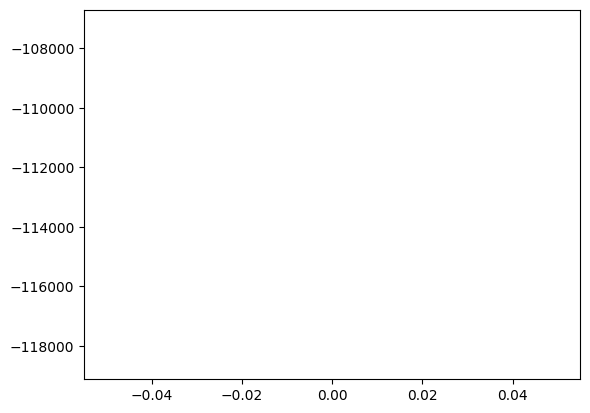

In [7]:
plt.plot(mean_reward)

In [2]:
import numpy as np
l = np.array([1,0, 1])
k = ''.join([str(x) for x in l])
hash(k)
key = lambda l : ''.join([str(x) for x in l])
key_to_np = lambda k : np.array(list(k), dtype=int)
print(key_to_np(key(l)))

[1 0 1]


In [27]:
import numpy as np
a = np.zeros(10)
a[1] = 1
a[5] = 1
np.where(a == 1)

(array([1, 5]),)

In [2]:
print(mean_reward, std_reward)

500.0 0.0


In [3]:
# Enjoy trained agent
vec_env = model.get_env()
obs = vec_env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = vec_env.step(action)
    vec_env.render("human")

: 

In [2]:
# rewards = []
# env.reset()
# env.render()
# done = False
# while not done:
#     action = 1
#     _, r, d, *_ = env.step(action)
#     done = d
#     rewards.append(r)
# env.render()
# t1_r = [r for r in rewards]
# # t2_r = [r[1] for r in rewards]
# print('transporter 1 total profit', sum(t1_r))
# # print('transporter 2 total profit', sum(t2_r))

def make_env():
    import gymnasium as gym
    e = gym.make('CartPole-v1')
    e.t = 16
    return e

In [3]:
# plt.plot(rewards)

## DQN

### Preliminaries

In [4]:
import torch
import gymnasium as gym

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from rlberry.agents import Agent
from rlberry.manager import AgentManager, plot_writer_data

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

# torch device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(torch.backends.mps.is_built())
print(device)

True
mps


In [5]:
from rlberry.agents import Agent

class MyAgent(Agent):
  name = "MyAgent"
  def __init__(self, env, **kwargs):
    """
    The base class (Agent) initializes:
      self.env : instance of the environment used for training (in fit() method)
      self.eval_env : instance of the environment used for evaluation (in eval() method)
      self.rng : random number generator (https://numpy.org/doc/stable/reference/random/generator.html)
      self.writer : use self.writer.add_scalar(tag, value, global_step) to log training data
    
    For reproducibility, use ONLY self.rng if you need random numbers in you agent!
    To be able to visualize plots with AgentManager, log data using self.writer (see below)
    """
    Agent.__init__(self, env, **kwargs)
    # self.param1 = param1
    # self.param2 = param2
    self.total_steps = 0
    self.total_episodes = 0

  def select_action(self, state, evaluation=False):
    """
    If evaluation=True, run evaluation policy (e.g., greedy with respect to Q)
    If evaluation=False, run exploration policy (e.g., epsilon greedy)
    """
    return self.env.action_space.sample()  # random action for this example

  def fit(self, budget):
    """budget = number of timesteps to train your agent"""
    state, _ = self.env.reset()
    episode_reward = 0.0
    for tt in range(budget):
      self.total_steps += 1
      action = self.select_action(state, evaluation=False)
      next_state, reward, done, *_ = self.env.step(action)
      episode_reward += reward
      # print(reward)

      # Log data
      self.writer.add_scalar('rewards', reward, global_step=self.total_steps)

      state = next_state 
      if done:
        self.total_episodes += 1
        # Log episode data
        self.writer.add_scalar('episode_rewards', episode_reward, global_step=self.total_steps)
        self.writer.add_scalar('episode', self.total_episodes, global_step=self.total_steps)

        state, _ = self.env.reset()
        episode_reward = 0.0
        
  
  def eval(self, **kwargs):
    """
    Here, you can run Monte-Carlo policy evaluation 
    with self.eval_env and return the result.
    Returning zero for this example.
    """
    return 0.0

In [6]:
#
# Initialize and train a single instance of MyAgent
#
env = gym.make('CartPole-v1')
my_agent = MyAgent(
    env=env,#(env, {}),       # tuple (constructor, kwargs)
    # param1=10,               # extra params your agent might need
    # param2=15
)
# train the agent for 100 timesteps
my_agent.fit(100)
# pandas DataFrame containing data stored with my_agent.writer.add_scalar(tag, value, global_step)
print(my_agent.writer.data)

#
# Run several instances of MyAgent in parallel and plot the results
#
manager_kwargs = dict(
    agent_class=MyAgent,
    train_env=(make_env, dict()),
    eval_env=(make_env, dict()),
    fit_budget=100,                    # Number of total timesteps
    n_fit=2,                           # Number of agent instances to fit
    parallelization='thread',          # Use 'thread' in the notebook!
    seed=456,                          # Seed
    default_writer_kwargs=dict(maxlen=100,log_interval=10),
)
my_agent_manager = AgentManager(
    # init_kwargs=dict(param1=10, param2=20),
    agent_name='MyAgent',
    **manager_kwargs
)
my_agent_manager.fit()   # Train 'n_fit' instances in parallel

[WARNING] 13:41: [Agent] Not possible to reseed environment. 
[WARNING] 13:41: [Agent] Not possible to reseed environment. 
[WARNING] 13:41: (Re)defining the following DefaultWriter parameters in AgentManager: ['maxlen', 'log_interval'] 
[INFO] 13:41: Running AgentManager fit() for MyAgent with n_fit = 2 and max_workers = None. 
[WARNING] 13:41: [Agent] Not possible to reseed environment. 
[WARNING] 13:41: [Agent] Not possible to reseed environment. 
[WARNING] 13:41: [Agent] Not possible to reseed environment. 
[WARNING] 13:41: [Agent] Not possible to reseed environment. 


        name      tag  value global_step  dw_time_elapsed
0    MyAgent  rewards    1.0           1         0.000215
1    MyAgent  rewards    1.0           2         0.000231
2    MyAgent  rewards    1.0           3         0.000241
3    MyAgent  rewards    1.0           4         0.000249
4    MyAgent  rewards    1.0           5         0.000257
..       ...      ...    ...         ...              ...
105  MyAgent  episode    1.0          16         0.000346
106  MyAgent  episode    2.0          26         0.000468
107  MyAgent  episode    3.0          38         0.000594
108  MyAgent  episode    4.0          85         0.000960
109  MyAgent  episode    5.0          99         0.001081

[110 rows x 5 columns]


[INFO] 13:41: ... trained! 
[WARNING] 13:41: [Agent] Not possible to reseed environment. 
[WARNING] 13:41: [Agent] Not possible to reseed environment. 
[WARNING] 13:41: [Agent] Not possible to reseed environment. 
[WARNING] 13:41: [Agent] Not possible to reseed environment. 


In [7]:
from gymnasium.wrappers import RecordVideo
%mkdir videos
# Initialize display and import function to show videos

def render_policy(env, agent):
  env = deepcopy(env)
  # env = RecordVideo(env, './videos')
  for episode in range(1):
    done = False
    state, _ = env.reset()
    env.render()
    while not done:
        action = agent.select_action(state, evaluation=True)
        state, reward, done, *_ = env.step(action)
    env.render()
    env.close()
    


mkdir: videos: File exists


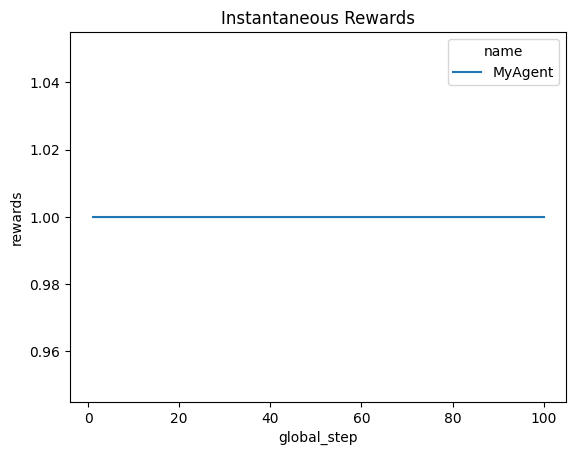

/opt/homebrew/lib/python3.10/site-packages/gymnasium/envs/classic_control/cartpole.py:212: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


In [8]:
# Plot the results
example_managers = []
example_managers.append(my_agent_manager)    # You could add more managers here, for other agents/parameters
_ = plot_writer_data(example_managers, tag='rewards', title='Instantaneous Rewards')
# _ = plot_writer_data(example_managers, tag='episode_rewards', xtag='episode', title='Episode Rewards')
# _ = plot_writer_data(example_managers, tag='episode_rewards', xtag='episode', title='Cumulative Episode Rewards', preprocess_func=np.cumsum)

# Render the policy of one of the trained agents
agent_instance = my_agent_manager.get_agent_instances()[0]
render_policy(agent_instance.eval_env, agent_instance)

In [9]:
class ReplayBuffer:
  def __init__(self, capacity, rng):
    """
    Parameters
    ----------
    capacity : int
      Maximum number of transitions
    rng : 
      instance of numpy's default_rng
    """
    self.capacity = capacity
    self.rng = rng  # random number generator
    self.memory = []
    self.position = 0

  def push(self, sample):
    """Saves a transition."""
    if len(self.memory) < self.capacity:
      self.memory.append(None)
    self.memory[self.position] = sample
    self.position = (self.position + 1) % self.capacity

  def sample(self, batch_size):
    indices = self.rng.choice(len(self.memory), size=batch_size)
    samples = [self.memory[idx] for idx in indices]
    return map(np.asarray, zip(*samples))

  def __len__(self):
    return len(self.memory)

In [10]:
class QNet(nn.Module):
  def __init__(self, obs_size, n_actions):
    super(QNet, self).__init__()
    
    #print(f'obs size = {obs_size}')
    self.lin1 = nn.Linear(obs_size, 64)
    self.lin2 = nn.Linear(64, 64)
    self.lin3 = nn.Linear(64, n_actions)
    #self.relu = nn.ReLU().to(device)

  def forward(self, state):

    if not isinstance(state, torch.Tensor):
      state = torch.tensor(state).float().to(device)
    #else :
    #  state = state.clone().detach().float().to(device)
    
    Q = F.relu(self.lin1(state))
    Q = F.relu(self.lin2(Q))
    return self.lin3(Q)

class DuelingQNet(nn.Module):
  def __init__(self, obs_size, n_actions):
    super(DuelingQNet, self).__init__()

    self.relu = nn.ReLU()
    self.lin = nn.Linear(obs_size, 64)

    # value function net
    self.val_lin1 = nn.Linear(64, 64)
    self.val_lin2 = nn.Linear(64, 1)

    # advantage function net
    self.adv_lin1 = nn.Linear(64, 64)
    self.adv_lin2 = nn.Linear(64, n_actions)

  def forward(self, state):

    if not isinstance(state, torch.Tensor):
      state = torch.tensor(state).float().to(device)
    #else :
      #state = state.clone().detach().float().to(device)

    y = self.lin(state)
    y = self.relu(y)

    # value function
    v = self.val_lin1(y)
    v = self.relu(v)
    v = self.val_lin2(v)

    # advantage function
    a = self.adv_lin1(y)
    a = self.relu(a)
    a = self.adv_lin2(a)

    return v + (a - torch.mean(a))
  
class LSTMQNet(nn.Module):
  def __init__(self, obs_size, n_actions):
    super(DuelingQNet, self).__init__()

    self.relu = nn.ReLU()
    self.lstm = nn.LSTM(obs_size, 64)

    self.lin1 = nn.Linear(64, 64)
    self.lin2 = nn.Linear(64, n_actions)

  def forward(self, state):

    if not isinstance(state, torch.Tensor):
      state = torch.tensor(state).float().to(device)
    #else :
      #state = state.clone().detach().float().to(device)

    y = self.lstm(state)
    y = self.relu(y)

    # value function
    v = self.lin1(y)
    v = self.relu(v)
    return self.lin2(v)

In [11]:
# Parameters
DQN_TRAINING_TIMESTEPS = 2_000  # number of timesteps for training. You might change this!

DQN_PARAMS = dict(
    dueling_dqn=False,         # set to true to use dueling DQN
    double_dqn=False,          # set to true to use double DQN
    gamma=0.99,
    batch_size=128,            # batch size (in number of transitions)
    eval_every=250,            # evaluate every ... steps
    buffer_capacity=30000,     # capacity of the replay buffer
    update_target_every=250,   # update target net every ... steps
    epsilon_start=1.0,         # initial value of epsilon
    epsilon_min=0.05,          # minimum value of epsilon
    decrease_epsilon=5000,     # parameter to decrease epsilon
    learning_rate=5e-4,       # learning rate
)
DUELING_DQN_PARAMS = deepcopy(DQN_PARAMS)           # dueling DQN
DOUBLE_DQN_PARAMS = deepcopy(DQN_PARAMS)            # double DQN
DOUBLE_DUELING_DQN_PARAMS = deepcopy(DQN_PARAMS)    # double & dueling DQN
# LSTM_DQN_PARAMS = deepcopy(DQN_PARAMS)

DUELING_DQN_PARAMS.update(dict(dueling_dqn=True))
DOUBLE_DQN_PARAMS.update(dict(double_dqn=True))
DOUBLE_DUELING_DQN_PARAMS.update(dueling_dqn=True, double_dqn=True)
# LSTM_DQN_PARAMS.update(dict(rnn = False))



In [12]:
class DQNAgent(Agent):
  name = 'DQN'
  def __init__(
      self,
      env,
      dueling_dqn: bool,               # Set to true for dueling DQN
      double_dqn: bool,                # Set to true for double DQN
      gamma: float = 0.99,
      batch_size: int = 256,
      eval_every: int = 250,
      buffer_capacity: int = 30000,
      update_target_every: int = 500,
      epsilon_start: float = 1.0,
      epsilon_min: float = 0.05,
      decrease_epsilon: int = 200,
      learning_rate: float = 0.001,
      **kwargs):
    Agent.__init__(self, env, **kwargs)
    env = self.env
    self.dueling_dqn = dueling_dqn
    self.double_dqn = double_dqn
    self.gamma = gamma
    self.batch_size = batch_size
    self.eval_every = eval_every
    self.update_target_every = update_target_every
    self.epsilon_start = epsilon_start
    self.epsilon_min = epsilon_min
    self.decrease_epsilon = decrease_epsilon
    self.total_timesteps = 0
    self.total_episodes = 0
    self.total_updates = 0

    # initialize epsilon
    self.epsilon = epsilon_start

    # initialize replay buffer
    self.replay_buffer = ReplayBuffer(buffer_capacity, self.rng)

    # select network class
    if self.dueling_dqn:
      net_class = DuelingQNet
    else:
      net_class = QNet
      
    # if self.rnn:
      # net_class = LSTMQNet

    # update name according to params
    if self.dueling_dqn:
      self.name = 'Dueling' + self.name
    if self.double_dqn:
      self.name = 'Double' + self.name

    # create network and target network
    obs_size = env.observation_space.shape[0]
    n_actions = env.action_space.n
    self.q_net = net_class(obs_size, n_actions).to(device)
    self.target_net = net_class(obs_size, n_actions).to(device)
    self.target_net.load_state_dict(self.q_net.state_dict())
    self.target_net.eval()
    
    # objective and optimizer
    self.optimizer = optim.Adam(
        params=self.q_net.parameters(), lr=learning_rate)
    self.loss_fn = nn.MSELoss()

  def select_action(self, state, evaluation=False):
    """
    If evaluation=False, get action according to exploration policy.
    Otherwise, get action according to the evaluation policy.
    """
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # TODO: implement action selection strategy
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    #print(f'random action = {self.env.action_space.sample()}')
    
    if self.rng.uniform() < self.epsilon and (not evaluation):
      action = self.env.action_space.sample()   # this happens with probability epsilon
    else:
      with torch.no_grad():
        action = torch.argmax(self.q_net(state)).item()

    return action # replace by the action you computed
  
  #@torch.compile
  def _update(self, batch_state, batch_action, batch_next_state, batch_reward):
    # values = Q(s_t, a_t), for t in batch
        values = self.q_net(batch_state).gather(1, batch_action.long())

        if not self.double_dqn:
          # !!!!!!!!!!!!!!!!!!!!!!!!!!
          # TO DO: compute DQN targets
          # !!!!!!!!!!!!!!!!!!!!!!!!!!

          with torch.no_grad():
            #next_state_values = torch.zeros(self.batch_size, device=device)
            next_state_values = self.target_net(batch_next_state).max(1)[0].unsqueeze(1).to(device)
            targets = (next_state_values * self.gamma) + batch_reward
      
        else:
          # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
          # TO DO: compute Double DQN targets
          # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

          with torch.no_grad():
            next_state_values = self.target_net(batch_next_state).gather(1, torch.argmax(self.q_net(batch_next_state), dim=1).unsqueeze(1)).to(device)
            targets = (next_state_values * self.gamma) + batch_reward


        loss = self.loss_fn(values, targets)#.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        #for param in self.q_net.parameters():
        #  param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        return loss

  def fit(self, budget):
    """
    budget : number of training timesteps
    """
    state, _ = self.env.reset()
    done = False
    episode_reward = 0.0
    for tt in range(budget):
      self.total_timesteps += 1
      # if self.env.t < 15:
      #   action = 0
      # else:
      action = self.select_action(state, evaluation=False)
      next_state, reward, done, *_ = self.env.step(action)
      episode_reward += reward
      # if not done :
      #   self.replay_buffer.push((state, next_state, action, reward, done))
      # else :
      #   self.replay_buffer.push((state, next_state, action, -reward, done))
      self.replay_buffer.push((state, next_state, action, float(not done)*reward, done))
        
      if len(self.replay_buffer) > self.batch_size:
        #
        # Update model
        #
        self.total_updates += 1

        # get batch
        (batch_state, batch_next_state,
         batch_action, batch_reward,
         batch_done) = self.replay_buffer.sample(self.batch_size)
        # convert to torch tensors
        batch_state = torch.FloatTensor(batch_state).to(device)
        batch_next_state = torch.FloatTensor(batch_next_state).to(device)
        batch_action = torch.LongTensor(batch_action).unsqueeze(1).to(device)
        batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
        batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

        # decrease epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon -= (self.epsilon_start 
                             - self.epsilon_min) / self.decrease_epsilon

        #
        #  TO DO: compute loss and update networks
        #
        loss = self._update(batch_state, batch_action, batch_next_state, batch_reward)
        

        self.writer.add_scalar('loss', loss.item(), self.total_timesteps)

      # evaluate agent
      if self.total_timesteps % self.eval_every == 0:
          mean_rewards = self.eval(n_sim=2)
          self.writer.add_scalar(
              'eval_rewards', mean_rewards, self.total_timesteps)
      
      # update target network
      if self.total_updates % self.update_target_every == 0:
          self.target_net.load_state_dict(self.q_net.state_dict())
          self.target_net.eval()

      # check end of episode
      state = next_state
      if done:
        state, _ = self.env.reset()
        self.total_episodes += 1
        self.writer.add_scalar(
                'episode_rewards', episode_reward, self.total_timesteps)
        self.writer.add_scalar(
                'episode', self.total_episodes, self.total_timesteps)
        episode_reward = 0.0

  def eval(self, n_sim=1, **kwargs):
    rewards = np.zeros(n_sim)
    eval_env = self.eval_env     # evaluation environment
    # Loop over number of simulations
    for sim in range(n_sim):
      state, _ = eval_env.reset()
      done = False
      while not done:
        action = self.select_action(state, evaluation=True)
        #print(f'action = {type(action)}')
        next_state, reward, done, *_ = eval_env.step(action)
        # update sum of rewards
        rewards[sim] += reward
        state = next_state
    return rewards.mean()

In [13]:
# # Training one instance of DQN
# dqn_agent = DQNAgent(
#     env=(get_env, dict()),  # we can send (constructor, kwargs) as an env
#     **DQN_PARAMS
# )
# dqn_agent.fit(DQN_TRAINING_TIMESTEPS)

#
# Training several instances using AgentManager
#
    
manager_kwargs = dict(
    agent_class=DQNAgent,
    train_env=(make_env, dict()),
    eval_env=(make_env, dict()),
    fit_budget=DQN_TRAINING_TIMESTEPS,
    n_fit=3,                   # NOTE: You may increase this parameter (number of agents to train)
    parallelization='process',
    seed=456,
    default_writer_kwargs=dict(maxlen=None,log_interval=10),
)

In [14]:
# DQN
dqn_manager = AgentManager(
    init_kwargs=DOUBLE_DQN_PARAMS,
    agent_name='DQN',
    **manager_kwargs
)
dqn_manager.fit()

[WARNING] 13:41: (Re)defining the following DefaultWriter parameters in AgentManager: ['maxlen', 'log_interval'] 
[INFO] 13:41: Running AgentManager fit() for DQN with n_fit = 3 and max_workers = None. 
Process SpawnProcess-3:
Traceback (most recent call last):
Process SpawnProcess-4:
  File "/opt/homebrew/Cellar/python@3.10/3.10.11/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/homebrew/Cellar/python@3.10/3.10.11/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Cellar/python@3.10/3.10.11/Frameworks/Python.framework/Versions/3.10/lib/python3.10/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
  File "/opt/homebrew/Cellar/python@3.10/3.10.11/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/queues.py"

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

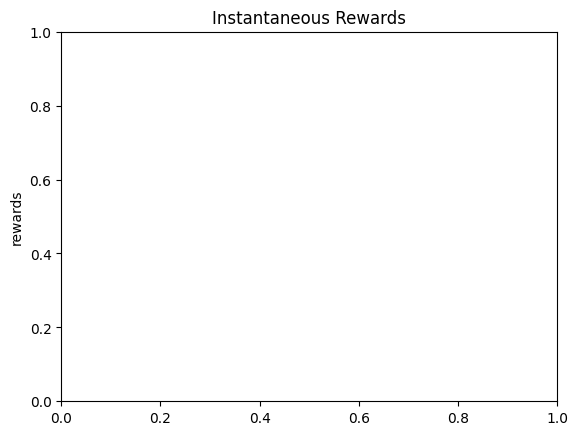

KeyError: 'episode'

In [ ]:
# Plot the results
_ = plot_writer_data(dqn_manager, tag='rewards', title='Instantaneous Rewards')
# _ = plot_writer_data(dqn_manager, tag='episode_rewards', xtag='episode', title='Episode Rewards')
# _ = plot_writer_data(dqn_manager, tag='episode_rewards', xtag='episode', title='Cumulative Episode Rewards', preprocess_func=np.cumsum)

# Render the policy of one of the trained agents
agent_instance = dqn_manager.get_agent_instances()[0]
render_policy(agent_instance.eval_env, agent_instance)

In [ ]:
import ray
from ray.rllib.algorithms.sac import sac
from transporter_env import TransportEnv, MAT, OneDynamicTransporter
from ray.rllib.policy.policy import PolicySpec

import pandas as pd
import json
import os
import shutil
import sys

checkpoint_root = "./ma_sac"
# Where checkpoints are written:
shutil.rmtree(checkpoint_root, ignore_errors=True, onerror=None)

# Where some data will be written and used by Tensorboard below:
ray_results = f'{os.getenv("HOME")}/ray_results/'
shutil.rmtree(ray_results, ignore_errors=True, onerror=None)

info = ray.init(ignore_reinit_error=True)
print("Dashboard URL: http://{}".format(info["webui_url"]))

from ray.tune.registry import register_env

# register_env("MAT", MAT)

#Configs
N_ITER = 1000                                     # Number of training runs.

config = sac.SACConfig()             # PPO's default configuration. See the next code cell.
config = config.environment(env=MAT, disable_env_checking=False)
# config = config.training(
#     num_sgd_iter = 10, # Number of SGD (stochastic gradient descent) iterations per training minibatch.
#     #vf_clip_param = 100,
# ) 
config = config.framework('torch')

config = config.rollouts(num_rollout_workers=4) 
config = config.multi_agent(
    policies = {
        "0" : PolicySpec(config=sac.SACConfig.overrides()), 
        "1" : PolicySpec(config=sac.SACConfig.overrides())
    },
    policy_mapping_fn = (lambda agent_id, *args, **kwargs: agent_id),
)

algo = config.build()  
algo.train() 
# Other settings we might adjust:
# config["num_workers"] = 10                       # Use > 1 for using more CPU cores, including over a cluster
                                                # I.e., for each minibatch of data, do this many passes over it to train. 
# config["model"]["fcnet_hiddens"] = [100, 50]    #

# config.environment(disable_env_checking=True)

# from ray.rllib.policy.policy import PolicySpec, Policy
    
# def policy_mapping_fn(agent_id, episode, worker, **kwargs):
#     return agent_id

    

# config["multiagent"] = {
#     "policies" : {
#         "0" : PolicySpec(
#             action_space=env.action_space
#         ),
#         "1" : PolicySpec(
#             action_space=env.action_space
#         )
#     },
#     "policy_mapping_fn":
#             policy_mapping_fn,
#     "policies_to_train": ["0", "1"],
# }

# #Trainer
# agent = ppo.PPOTrainer(config, env=SELECT_ENV)

# results = []
# episode_data = []
# episode_json = []

# for n in range(N_ITER):
#     result = agent.train()
#     results.append(result)
    
#     episode = {'n': n, 
#                'episode_reward_min': result['episode_reward_min'], 
#                'episode_reward_mean': result['episode_reward_mean'], 
#                'episode_reward_max': result['episode_reward_max'],  
#                'episode_len_mean': result['episode_len_mean']}
    
#     episode_data.append(episode)
#     episode_json.append(json.dumps(episode))
#     file_name = agent.save(checkpoint_root)
    
#     print(f'{n:3d}: Min/Mean/Max reward: {result["episode_reward_min"]:8.4f}/{result["episode_reward_mean"]:8.4f}/{result["episode_reward_max"]:8.4f}. Checkpoint saved to {file_name}')

#     with open('ma_ppo3/rewards.json', 'w') as outfile:
#         json.dump(episode_json, outfile)

2023-03-11 12:28:20,264	INFO worker.py:1382 -- Calling ray.init() again after it has already been called.


Dashboard URL: http://
(autoscaler +7m54s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


2023-03-11 12:28:36,134	INFO trainable.py:172 -- Trainable.setup took 15.860 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-03-11 12:28:36,135	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-03-11 12:28:36,143	ERROR actor_manager.py:496 -- Ray error, taking actor 1 out of service. ray::RolloutWorker.apply() (pid=14413, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x300f57b50>)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/utils/actor_manager.py", line 183, in apply
    raise e
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/utils/actor_manager.py", line 174, in apply
    return func(self, *args, **kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/execution/rollout_ops.py", line 86, in <lambda>
    lambda w: w.sample(), local_worker=False, healthy_only=True
  File "/opt/homebrew/lib/python3.10/site-packages/

(RolloutWorker pid=14415) obs is : {}
(RolloutWorker pid=14415) ids is : []


(RolloutWorker pid=14415) /opt/homebrew/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=14415)   gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=14413) /opt/homebrew/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=14413)   gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=14413) 2023-03-11 12:28:36,068	WARNING env.py:296 -- Your MultiAgentEnv <MAT instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__()` from within your MutiAgentEnv's constructor. This will raise an error in the future.
(RolloutWorker pid=14414) /opt/homebrew/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32

RayTaskError(KeyError): [36mray::RolloutWorker.apply()[39m (pid=14413, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x300f57b50>)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/utils/actor_manager.py", line 183, in apply
    raise e
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/utils/actor_manager.py", line 174, in apply
    return func(self, *args, **kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/execution/rollout_ops.py", line 86, in <lambda>
    lambda w: w.sample(), local_worker=False, healthy_only=True
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/evaluation/rollout_worker.py", line 914, in sample
    batches = [self.input_reader.next()]
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/evaluation/sampler.py", line 92, in next
    batches = [self.get_data()]
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/evaluation/sampler.py", line 277, in get_data
    item = next(self._env_runner)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/evaluation/env_runner_v2.py", line 323, in run
    outputs = self.step()
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/evaluation/env_runner_v2.py", line 379, in step
    self._base_env.send_actions(actions_to_send)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/env/multi_agent_env.py", line 656, in send_actions
    raise e
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/env/multi_agent_env.py", line 645, in send_actions
    obs, rewards, terminateds, truncateds, infos = env.step(agent_dict)
  File "/Users/faridounet/PhD/TransportersDilemma/transporter_env.py", line 236, in step
    return self.env.step(actions)
  File "/Users/faridounet/PhD/TransportersDilemma/transporter_env.py", line 197, in step
    return self._get_state(), self._get_rewards(actions), done, trunc, self._get_info()
  File "/Users/faridounet/PhD/TransportersDilemma/transporter_env.py", line 150, in _get_rewards
    node = int(self.obs["0"][2])
KeyError: '0'

(RolloutWorker pid=14414) obs is : {}
(RolloutWorker pid=14414) ids is : []
(RolloutWorker pid=14413) obs is : {}
(RolloutWorker pid=14413) ids is : []
(RolloutWorker pid=14416) obs is : {}
(RolloutWorker pid=14416) ids is : []


In [ ]:
import ray
from ray.rllib.algorithms.ppo import ppo
from transporter_env import TransportEnv, MAT, OneDynamicTransporter

import pandas as pd
import json
import os
import shutil
import sys

checkpoint_root = "./ma_ppo"
# Where checkpoints are written:
shutil.rmtree(checkpoint_root, ignore_errors=True, onerror=None)

# Where some data will be written and used by Tensorboard below:
ray_results = f'{os.getenv("HOME")}/ray_results/'
shutil.rmtree(ray_results, ignore_errors=True, onerror=None)

info = ray.init(ignore_reinit_error=True)
print("Dashboard URL: http://{}".format(info["webui_url"]))

from ray.tune.registry import register_env
from transporter_env import OneDynamicTransporter

# register_env("OneDynamicTransporter", OneDynamicTransporter)

#Configs
N_ITER = 1000                                     # Number of training runs.

config = ppo.PPOConfig()             # PPO's default configuration. See the next code cell.
config = config.environment(env=OneDynamicTransporter, disable_env_checking=True)
config = config.training(
    num_sgd_iter = 10, # Number of SGD (stochastic gradient descent) iterations per training minibatch.
    #vf_clip_param = 100,
) 
config = config.framework('torch')

config = config.rollouts(num_rollout_workers=4) 
# config = config.resources(num_gpus=1) 
# config = config.training(fcnet_hiddens =[128, 64] )
# config = config.multi_agent(
#     policies = {"0", "1"},
#     policy_mapping_fn = (lambda agent_id, *args, **kwargs: agent_id),
# )
# dic = config.to_dict()
# q_config = dic['q_model_config']
# q_config['fcnet_hiddens'] = [128, 64]
# policy_config = dic['policy_model_config']
# policy_config['fcnet_hiddens'] = [128, 64]
# config = config.training(
#     q_model_config = q_config,
#     policy_model_config = policy_config,
# )

print(config.to_dict())  

2023-03-11 14:36:47,210	INFO worker.py:1553 -- Started a local Ray instance.


Dashboard URL: http://
{'extra_python_environs_for_driver': {}, 'extra_python_environs_for_worker': {}, 'num_gpus': 0, 'num_cpus_per_worker': 1, 'num_gpus_per_worker': 0, '_fake_gpus': False, 'num_trainer_workers': 0, 'num_gpus_per_trainer_worker': 0, 'num_cpus_per_trainer_worker': 1, 'custom_resources_per_worker': {}, 'placement_strategy': 'PACK', 'eager_tracing': False, 'eager_max_retraces': 20, 'tf_session_args': {'intra_op_parallelism_threads': 2, 'inter_op_parallelism_threads': 2, 'gpu_options': {'allow_growth': True}, 'log_device_placement': False, 'device_count': {'CPU': 1}, 'allow_soft_placement': True}, 'local_tf_session_args': {'intra_op_parallelism_threads': 8, 'inter_op_parallelism_threads': 8}, 'env': <class 'transporter_env.OneDynamicTransporter'>, 'env_config': {}, 'observation_space': None, 'action_space': None, 'env_task_fn': None, 'render_env': False, 'clip_rewards': None, 'normalize_actions': True, 'clip_actions': False, 'disable_env_checking': True, 'is_atari': None

/var/folders/6y/xmdymgfj6t79xkdq239jvsmm0000gn/T/ipykernel_28195/1633673784.py:20: DeprecationWarning: Accessing values through ctx["webui_url"] is deprecated. Use ctx.address_info["webui_url"] instead.
  print("Dashboard URL: http://{}".format(info["webui_url"]))


In [ ]:
algo = config.build()  
# algo.train() 
# Other settings we might adjust:
# config["num_workers"] = 10                       # Use > 1 for using more CPU cores, including over a cluster
                                                # I.e., for each minibatch of data, do this many passes over it to train. 
# config["model"]["fcnet_hiddens"] = [100, 50]    #

# config.environment(disable_env_checking=True)

# from ray.rllib.policy.policy import PolicySpec, Policy
    
# def policy_mapping_fn(agent_id, episode, worker, **kwargs):
#     return agent_id

    

# config["multiagent"] = {
#     "policies" : {
#         "0" : PolicySpec(
#             action_space=env.action_space
#         ),
#         "1" : PolicySpec(
#             action_space=env.action_space
#         )
#     },
#     "policy_mapping_fn":
#             policy_mapping_fn,
#     "policies_to_train": ["0", "1"],
# }

#Trainer

results = []
episode_data = []
episode_json = []

for n in range(N_ITER):
    result = algo.train()
    results.append(result)
    
    episode = {'n': n, 
               'episode_reward_min': result['episode_reward_min'], 
               'episode_reward_mean': result['episode_reward_mean'], 
               'episode_reward_max': result['episode_reward_max'],  
               'episode_len_mean': result['episode_len_mean']}
    
    episode_data.append(episode)
    episode_json.append(json.dumps(episode))
    if n%100 == 0:
        file_name = algo.save(checkpoint_root)
    
    print(f'{n:3d}: Min/Mean/Max reward: {result["episode_reward_min"]:8.4f}/{result["episode_reward_mean"]:8.4f}/{result["episode_reward_max"]:8.4f}. Checkpoint saved to {file_name}')

    with open('ma_ppo/rewards.json', 'w') as outfile:
        json.dump(episode_json, outfile)

2023-03-11 14:36:49,500	WARNING unified.py:54 -- Could not instantiate TBXLogger: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates.
2023-03-11 14:36:49,501	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2023-03-11 14:36:51,559	WARNING util.py:67 -- Install gputil for GPU system monitoring.
(RolloutWorker pid=28254) /opt/homebrew/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision low

  0: Min/Mean/Max reward:   0.0000/  0.0000/  0.0000. Checkpoint saved to ./ma_ppo/checkpoint_000001


KeyboardInterrupt: 